# Setup

In [13]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import os

np.random.seed(42)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

# 投票分类器

In [24]:
aa = (np.random.rand(5, 3) < 0.51).astype(np.int32)
np.cumsum(aa, axis=0) / np.arange(1, 6).reshape(-1, 1), np.cumsum(aa, axis=0)

(array([[0.        , 0.        , 1.        ],
        [0.5       , 0.5       , 1.        ],
        [0.33333333, 0.33333333, 1.        ],
        [0.25      , 0.5       , 1.        ],
        [0.4       , 0.6       , 0.8       ]]),
 array([[0, 0, 1],
        [1, 1, 2],
        [1, 1, 3],
        [1, 2, 4],
        [2, 3, 4]], dtype=int32))

In [52]:
np.random.seed(42)
# 头朝上的概率
heads_praba = 0.51
n_tosses = 10000
# 投掷
coin_tosses = (np.random.rand(n_tosses, 10) < 0.51).astype(np.int32)
# 统计
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, n_tosses + 1).reshape(-1, 1)

大数定律


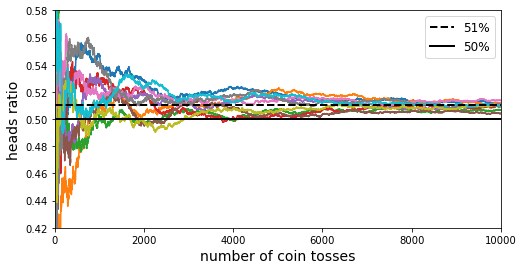

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, n_tosses], [heads_praba, heads_praba], "k--", linewidth=2, label="51%")
plt.plot([0, n_tosses], [0.5, 0.5], "k-", linewidth=2, label="50%")

plt.xlabel("number of coin tosses", fontsize=14)
plt.ylabel("heads ratio", fontsize=14)
plt.axis([0, n_tosses, 0.42, 0.58])
plt.legend(loc="upper right", fontsize=12)
print("大数定律")
plt.show()


创建并训练一个投票分类器（有三种不同的分类器组成）

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [61]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(estimators=[("lc", log_clf), ("rc", rnd_clf), ("sc", svm_clf)],
                             voting="hard")
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lc', LogisticRegression(random_state=42)),
                             ('rc', RandomForestClassifier(random_state=42)),
                             ('sc', SVC(random_state=42))])

每个分类器在测试集上的准确率

In [62]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_pred = accuracy_score(y_pred, y_test)
    
    print(clf.__class__.__name__ , accuracy_pred)

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [72]:
def voting_hard_or_soft(voting):
    log_clf = LogisticRegression(random_state=42)
    rnd_clf = RandomForestClassifier(random_state=42)
    svm_clf = SVC(random_state=42, probability=True if voting == "soft" else 0)

    voting_clf = VotingClassifier(estimators=[("lc", log_clf), ("rc", rnd_clf), ("sc", svm_clf)],
                                 voting=voting)
    voting_clf.fit(X_train, y_train)
    
    for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy_pred = accuracy_score(y_pred, y_test)

        print(clf.__class__.__name__ , accuracy_pred)

In [76]:
voting_hard_or_soft("soft")
print("------- hard-----------")
voting_hard_or_soft("hard")

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92
------- hard-----------
LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


# bagging and pasting

## Scikit-Learn 的 bagging 和 pasting

训练一个包含500个决策树分类器的集成，每次随机从训练集中采样100个训练实例进行训练，然后放回（bagging）。pasting（`bootstrap=False`）

In [81]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                           n_estimators=500,
                           max_samples=100,
                           bootstrap=True,
                           n_jobs=-1)

bag_clf.fit(X_train, y_train)

# 预测
y_pred = bag_clf.predict(X_test)
# 准确率
accuracy_score(y_test, y_pred)

0.92

In [82]:
tree_clf = DecisionTreeClassifier(random_state=42)

tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_pred_tree, y_test)


0.856

In [114]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.8, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_new_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_new_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_new_pred, alpha=0.8, cmap=custom_cmap2)
    
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14)
    plt.axis(axes)
    

Text(0.5, 1.0, 'Decision Tree With Bagging')

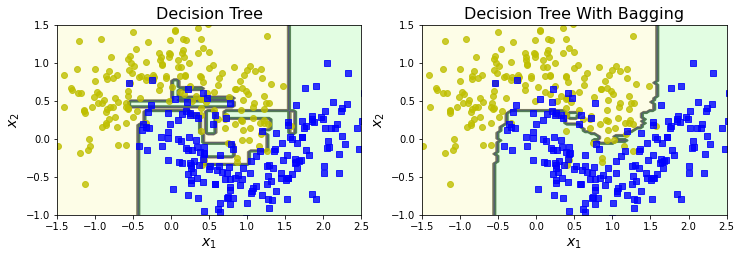

In [115]:
plt.figure(figsize=(12, 3.5))
plt.subplot(121)
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree", fontsize=16)

plt.subplot(122)
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Tree With Bagging", fontsize=16)




## 包外评估

In [131]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                            # splitter="random", max_leaf_nodes=16, random_state=42
                           n_estimators=500,
                           bootstrap=True,
                           n_jobs=-1,
                           oob_score=True,  # 保外评估
                            random_state=40
                           )
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [132]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [133]:
# 获得 每个训练实例的包外决策函数
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

# Random Patches 和随机子空间

# 随机森林

In [134]:
from sklearn.ensemble import RandomForestClassifier

# 训练一个拥有500棵树的随机森林分类器（每棵树限制最多有16个叶节点）
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)    
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [135]:
accuracy_score(y_pred_rf, y_test)

0.92

In [136]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
                           n_estimators=500, 
                           max_samples=1.0, 
                            bootstrap=True,
                            n_jobs=-1
                           )
bag_clf.fit(X_train, y_train)

y_pred_bf = bag_clf.predict(X_test)

In [137]:
accuracy_score(y_pred_bf, y_test)

0.904

In [139]:
# BaggingClassifier 和 RandomForestClassifier几乎相同的预测
np.sum(y_pred_rf == y_pred_bf) / len(y_pred_bf)

0.984

## 极端随机数

In [140]:
from sklearn.ensemble import ExtraTreesClassifier

# 训练一个拥有500棵树的随机森林分类器（每棵树限制最多有16个叶节点）
extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)    
extra_clf.fit(X_train, y_train)

y_pred_extra = extra_clf.predict(X_test)

In [141]:
accuracy_score(y_pred_extra, y_test)

0.92

## 特征重要性

In [143]:
from sklearn.datasets import load_iris

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["
                 data"], iris["target"])

# 特征，特征的重要程度
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)


sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


MNIST数据集上训练一个随机森林，然后绘制其每个像素的重要性

In [145]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.target = mnist.target.astype(np.int64)

In [146]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_estimators=10, random_state=42)

In [147]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=plt.cm.hot, interpolation="nearest")
    plt.axis("off")

[Text(1, 0, 'Not important'), Text(1, 0, 'very important')]

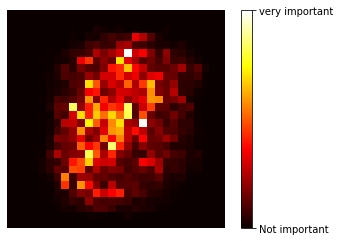

In [153]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not important", "very important"])

In [150]:
rnd_clf.feature_importances_.shape

(784,)

# 提升法

## AdaBoost

In [161]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=42),
                            n_estimators=200,
                             algorithm="SAMME.R",
                             learning_rate=0.5,
                             random_state=42
                            )
ada_clf.fit(X_train, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=42),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [162]:
y_pred_ada = ada_clf.predict(X_test)

accuracy_score(y_pred_ada, y_test)

0.896

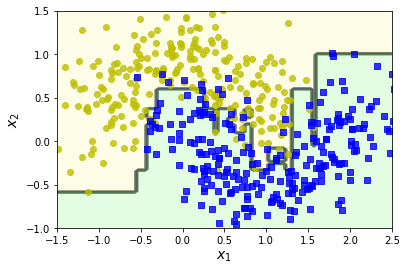

In [163]:
plot_decision_boundary(ada_clf, X, y)

In [166]:
np.ones(10) != np.arange(10)

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True])

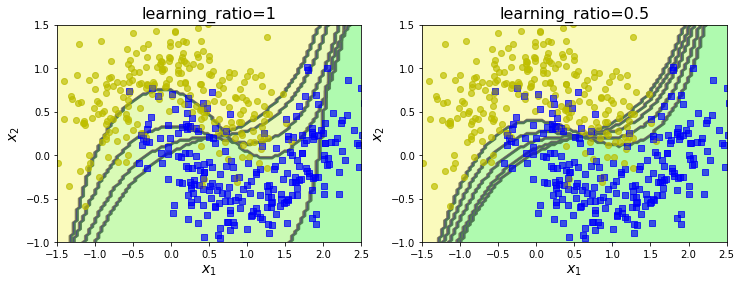

In [180]:
m = len(X_train)
plt.figure(figsize=(12, 4))

for subplot, learning_ratio in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        
        sample_weights[y_pred != y_train] *= (1 + learning_ratio)  # 预测错的实例，权重提升
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_ratio={}".format(learning_ratio), fontsize=16)
        
plt.show()

## 梯度提升

In [202]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [203]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)
y1 = tree_reg1.predict(X)

In [204]:
y2 = y - y1

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)
y2_ = tree_reg2.predict(X)

In [205]:
y3 = y2 - y2_

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)
y3_ = tree_reg3.predict(X)

In [206]:
X_new = np.array([[0.8]])

In [207]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)) 

In [208]:
y_pred

array([0.75026781])

In [209]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt_reg = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1, random_state=42)
gbrt_reg.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3,
                          random_state=42)

In [210]:
gbrt_reg.predict(X_new)

array([0.75026781])

In [237]:
def plot_predictions(regs, X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                     pred_style="r-", data_style="b.", pred_label=None, data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(reg.predict(x1.reshape(-1, 1)) for reg in regs)
    
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, pred_style, label=pred_label)
    
    if pred_label or data_label:
        plt.legend(loc="upper center", fontsize=12)
    plt.axis(axes)

Text(0.5, 0, '$x_1$')

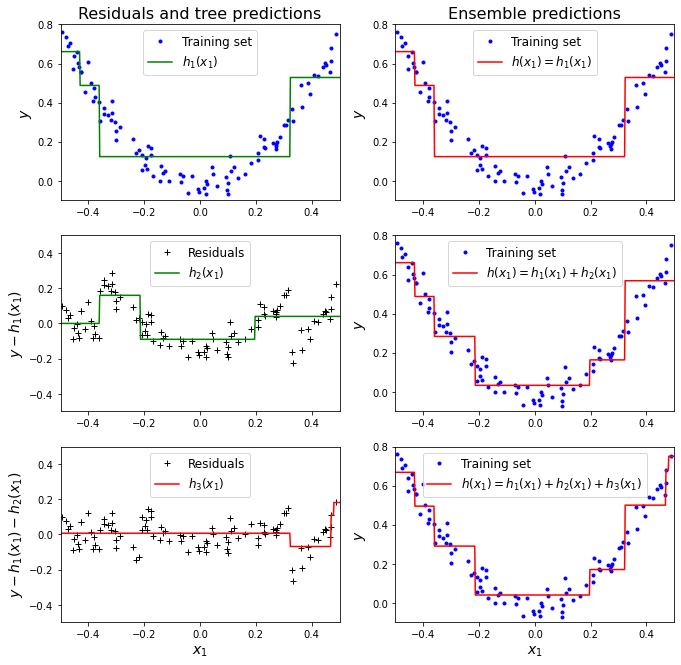

In [228]:
plt.figure(figsize=(11, 11))
plt.subplot(321)
plot_predictions([tree_reg1], X, y, pred_style="g-", pred_label="$h_1(x_1)$", data_label="Training set")
plt.title("Residuals and tree predictions", fontsize=16)
plt.ylabel("$y$", fontsize=14)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, pred_label="$h(x_1)=h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions", fontsize=16)
plt.ylabel("$y$", fontsize=14)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, pred_style="g-", data_style="k+", axes=[-0.5, 0.5, -0.5, 0.5],
                 pred_label="$h_2(x_1)$", data_label="Residuals")
plt.ylabel("$y-h_1(x_1)$", fontsize=14)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, pred_label="$h(x_1)=h_1(x_1)+h_2(x_1)$", 
                 data_label="Training set")
plt.ylabel("$y$", fontsize=14)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, data_style="k+", axes=[-0.5, 0.5, -0.5, 0.5],
                 pred_label="$h_3(x_1)$", data_label="Residuals")
plt.ylabel("$y-h_1(x_1)-h_2(x_1)$", fontsize=14)
plt.xlabel("$x_1$", fontsize=14)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, 
                 pred_label="$h(x_1)=h_1(x_1)+h_2(x_1)+h_3(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=14)
plt.xlabel("$x_1$", fontsize=14)


In [234]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)

gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3)

In [235]:
gbrt.predict(X_new)

array([0.75026781])

寻找树的最佳数量

In [263]:
gbrt_reg_n3 = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt_reg_n3.fit(X, y)

gbrt_reg_n200 = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_reg_n200.fit(X, y)

gbrt_reg_n100 = GradientBoostingRegressor(max_depth=2, n_estimators=55, learning_rate=0.1, random_state=42)
gbrt_reg_n100.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=55, random_state=42)

Text(0.5, 1.0, 'leaning_ratio=0.1, n_estimatos=55')

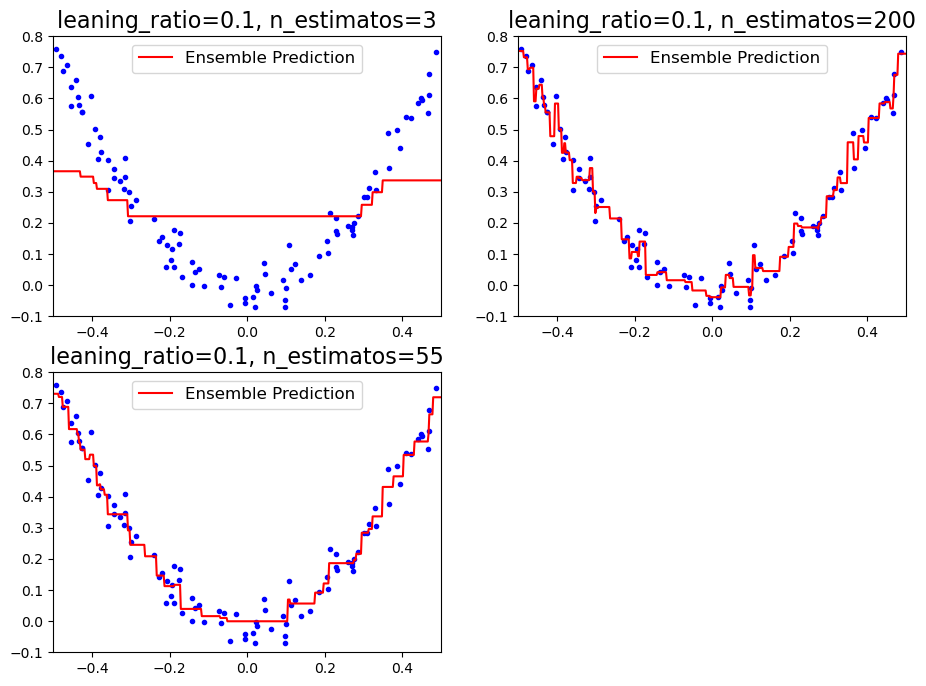

In [324]:
plt.figure(figsize=(11, 8))
plt.subplot(221)
plot_predictions([gbrt_reg_n3], X, y, pred_label="Ensemble Prediction")
plt.title("leaning_ratio={}, n_estimatos={}".format(gbrt_reg_n3.learning_rate, gbrt_reg_n3.n_estimators), 
         fontsize=16)

plt.subplot(222)
plot_predictions([gbrt_reg_n200], X, y, pred_label="Ensemble Prediction")
plt.title("leaning_ratio={}, n_estimatos={}".format(gbrt_reg_n200.learning_rate, gbrt_reg_n200.n_estimators), 
         fontsize=16)

plt.subplot(223)
plot_predictions([gbrt_reg_n100], X, y, pred_label="Ensemble Prediction")
plt.title("leaning_ratio={}, n_estimatos={}".format(gbrt_reg_n100.learning_rate, gbrt_reg_n100.n_estimators), 
         fontsize=16)


In [325]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_pred, y_val) for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=2, n_estimators=55)

In [326]:
min_error = np.min(errors)
print("min_error:", min_error)
print("bst_n_estimators:", bst_n_estimators)


min_error: 0.002712853325235463
bst_n_estimators: 55


通过早期停止法调整树的数量


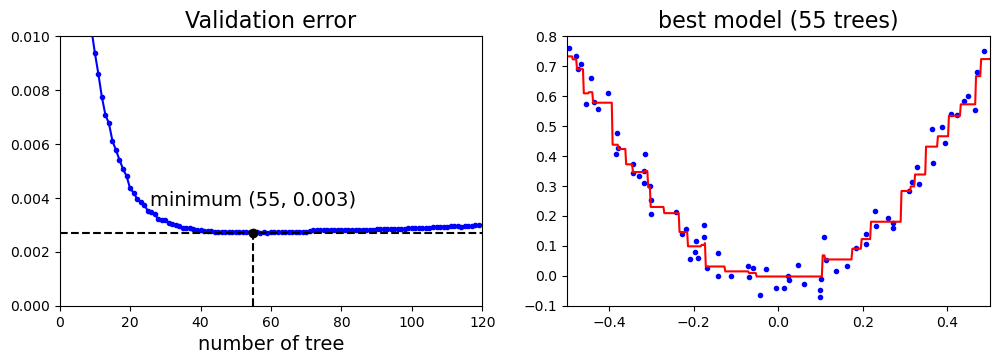

In [328]:
#解决中文显示问题
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
# 恢复默认
# mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(12, 3.5))

plt.subplot(121)
plt.plot(errors, "b.-")
# plt.plot(np.arange(1, 121), errors, "k-", linewidth=2)
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error + 0.001, "minimum ({}, {})".format(bst_n_estimators, round(min_error, 3)), 
         ha="center", fontsize=14)

plt.title("Validation error", fontsize=16)
# plt.title("Validation error（验证误差）", fontsize=16)
plt.xlabel("number of tree", fontsize=14)
plt.axis([0, 120, 0, 0.01])

plt.subplot(122)
plot_predictions([gbrt_best], X_train, y_train)
plt.title("best model ({} trees)".format(bst_n_estimators), fontsize=16)

print("通过早期停止法调整树的数量")
plt.show()

提前停止训练（`warm_start=True`）

In [336]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    
    y_pred = gbrt.predict(X_val)
    
    val_error = mean_squared_error(y_val, y_pred)
    if min_val_error > val_error:
        min_val_error = val_error
        error_going_up = 0 
    else:
        error_going_up += 1
        if error_going_up >= 5:
            break

In [338]:
print("min_val_error: ", min_val_error)
print("gbrt.n_estimators: ", gbrt.n_estimators)

min_val_error:  0.002712853325235463
gbrt.n_estimators:  61


# 堆叠法

# 练习

In [233]:
a = np.array([[6, 8, 3, 0],
              [3, 2, 1, 7],
              [8, 1, 8, 4],
              [5, 3, 8, 5],
              [5, 7, 5, 9]])
from scipy import stats
stats.mode(a, axis=0)

ModeResult(mode=array([[5, 1, 8, 0]]), count=array([[2, 1, 2, 1]]))